In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

In [ ]:
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [361]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=25000)

## Pre-processing

In [362]:
massive.head(1)

,id,title,audienceScore,tomatoMeter,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,delta
727501,forgetting_sarah_marshall,Forgetting Sarah Marshall,76.0,83.0,1721200,2008-04-10,Urban Cinefile Critics,False,fresh,Urban Cinefile,There's a lot to like in Forgetting Sarah Mars...,POSITIVE,7.0


In [363]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive = massive.reset_index(drop=True)

In [364]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
dtype: int64

In [365]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title             14762
tomatoMeter       24861
criticName        21155
publicatioName    23295
reviewText            0
scoreSentiment    24959
delta             24831
dtype: int64

<AxesSubplot:xlabel='publicatioName', ylabel='Count'>

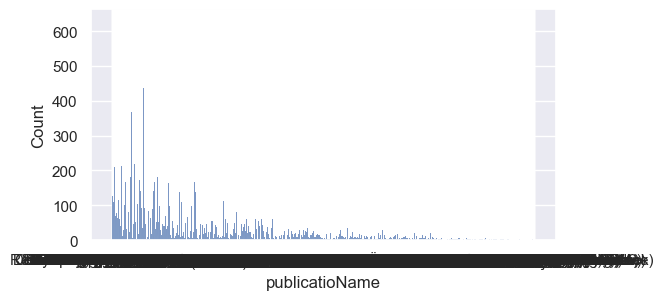

In [370]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='publicatioName')

<AxesSubplot:xlabel='criticName', ylabel='Count'>

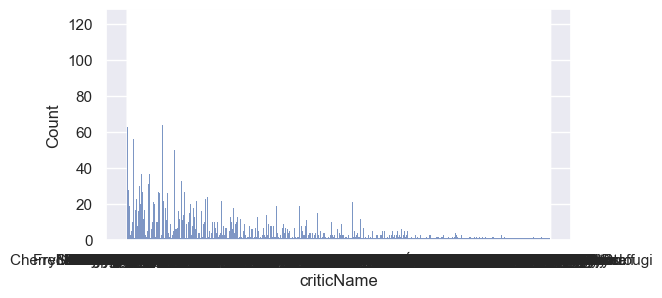

In [151]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='criticName')

array([[<AxesSubplot:title={'center':'delta'}>]], dtype=object)

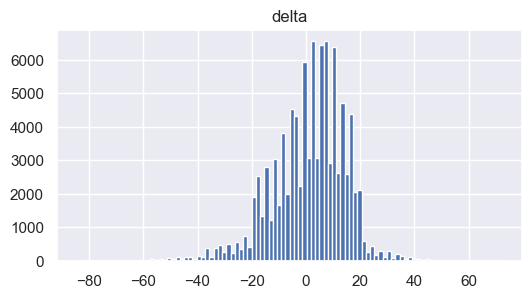

In [274]:
massive.hist(column='delta', bins=100)

In [275]:
# define a function to process text on the data
lemmatizer = WordNetLemmatizer()
import re
def process_text(text): 
    sw = set(stopwords.words('english')) 
    regex = re.compile("[^a-zA-Z ]") 
    re_clean = regex.sub('', text) 
    words = word_tokenize(re_clean) 
    lem = [lemmatizer.lemmatize(word) for word in words] 
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw]) 
    return output

In [276]:
# use a lambda x function to apple process text on the whole column.
massive_lemma = massive.copy()
massive_lemma['reviewText'] = massive_lemma['reviewText'].apply(lambda x: process_text(x))
massive_lemma = massive_lemma.reset_index(drop=True)
massive_lemma.head(2)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta
0,12 Monkeys,88.0,Matthew Pejkovic,Matt's Movie Reviews,dark gritty scifi thriller monkeys stand apart...,POSITIVE,0.0
1,I Know Who Killed Me,9.0,Jan Stuart,Newsday,know killed ostensibly horror thriller slicean...,NEGATIVE,-17.0


## TFIDF Vectorizer and Logistic Regression (sentiment model)

In [487]:
# tfidf vectorizer for sentiment model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = massive_lemma['reviewText']
y = massive_lemma['scoreSentiment']
X_v = tfidf_vectorizer.fit_transform(X)

In [444]:
# Split the data into training and testing sets for sentiment model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [445]:
X_train_v = tfidf_vectorizer.fit_transform(X_train)
X_test_v = tfidf_vectorizer.transform(X_test)
# Choose a machine learning model (e.g., Logistic Regression) and train it
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(X_train_v, y_train)

LogisticRegression(max_iter=5000)

In [254]:
model.score(X_train, y_train)

0.8237230823990034

In [255]:
model.score(X_test, y_test)

0.8113157192420604

In [213]:
# Classification Report, Confusion Matrix
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.28      0.40      1104
    POSITIVE       0.76      0.95      0.85      2643

    accuracy                           0.76      3747
   macro avg       0.74      0.62      0.62      3747
weighted avg       0.75      0.76      0.72      3747



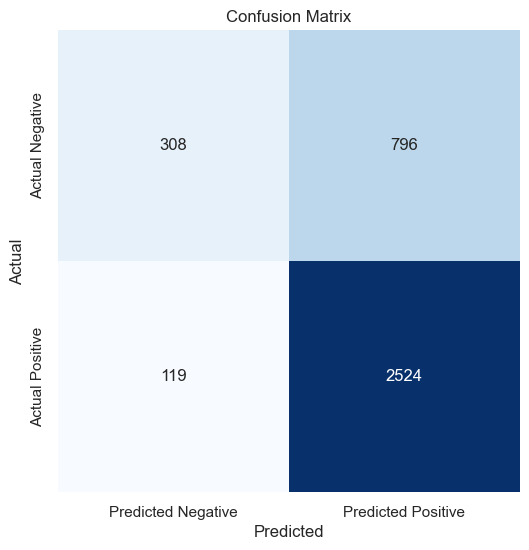

In [373]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            square=True, xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Log_Regression_Sentiment_Confusion_Matrix')
plt.show()

## LIME

In [504]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from bs4 import BeautifulSoup

In [505]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [506]:
massive['cleaned'] = massive['reviewText'].apply(clean_text)

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [510]:
list_corpus = massive["cleaned"].tolist()
list_labels = massive["scoreSentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
train_vectors = tfidf_vectorizer.fit_transform(X_train)
test_vectors = tfidf_vectorizer.transform(X_test)

In [514]:
logreg = LogisticRegression(max_iter=5000, n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)
pred = logreg.predict(test_vectors)
print(f'accuracy = {accuracy_score(y_test, pred)}')

accuracy = 0.7352293210494693


In [518]:
c = make_pipeline(tfidf_vectorizer, logreg)
class_names=list(massive.scoreSentiment.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 1877
predicted_class = logreg.predict(test_vectors[idx]).reshape(1, -1)[0, 0]
predicted_class_index = int(predicted_class)
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[0, 1])
print('Document id: %d' % idx)
print('Predicted class =', class_names[predicted_class_index])
print('True class: %s' % class_names[y_test[idx]])

ValueError: invalid literal for int() with base 10: 'NEGATIVE'

In [519]:
c = make_pipeline(tfidf_vectorizer, logreg)
class_names = list(massive.scoreSentiment.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 1877
predicted_class = logreg.predict(test_vectors[idx]).reshape(1, -1)[0, 0]
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=class_names)
print('Document id: %d' % idx)
print('Predicted class =', predicted_class)
print('True class: %s' % class_names[y_test[idx]])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## SHAP and BERT

In [488]:
explainer = shap.Explainer(model, X_v, feature_names=tfidf_vectorizer.get_feature_names_out())
shap_values = explainer(X_v)

In [521]:
X[0]

'dark gritty scifi thriller monkeys stand apart scifi film due unique twisted concept future mankind'

In [490]:
# Visualize SHAP values as text
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.beeswarm(shap_values[100:3550])
#plt.savefig('Sentiment_shap_beeswarm_plot.png', bbox_inches='tight')

In [ ]:
shap.summary_plot(shap_values, X_train_v)

In [ ]:
shap.plots.bar(shap_values.min(0))

In [ ]:
shap.plots.bar(shap_values.sum(0))

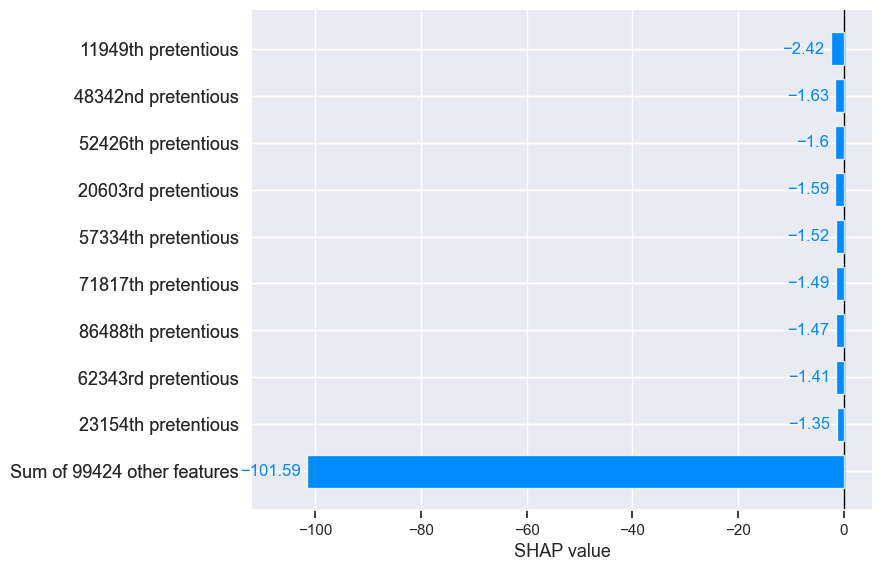

In [502]:
shap.plots.bar(shap_values[:, "pretentious"])

In [479]:
decoded_text = tfidf_vectorizer.inverse_transform(X_test_v)
original_review = ' '.join(decoded_text[19669])
print(original_review)

milieu fool tony


In [482]:
X_test

26115    auerbach ha resurrected butlers career buried ...
29641                          bad film leaf amusing sting
75767    squandering space time actorparttime screenwri...
83349    film manages present genre knowing wink give n...
91390    itforces u reconsider body work far expansive ...
                               ...                        
79329    littleknown attractive brit marling certainly ...
65477    surface dumplin slight charming comedy beauty ...
74956    uneven humor relying heavily stereotype leaf d...
97718    even villeneuve tasked actor reading herberts ...
70462      vulgar ridiculous offensive absolutely riveting
Name: reviewText, Length: 24859, dtype: object

In [484]:
print(X_test[19669])
#print(X_test.loc[19669, 'title'])

KeyError: 19669

### Processing for Linear Regression

In [13]:
# Creating a dataframe made of the vectorized review text for the linear model
massive_features = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
massive_features.head(2)

,aaron,abandon,abandoned,ability,able,aboard,abrams,abrupt,absence,absent,...,youngster,youre,youth,youthful,youve,zack,zany,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Need to rename column because title is also a column in massive_features
massive = massive.rename(columns={'title': 'title_'})

### Second TFIDF vectorizer for Linear Regression (Predicting Delta)

In [16]:
# Vectorizing original df to dense array for linear model
tfidf_dense = tfidf_vectorizer.fit_transform(massive['reviewText']).todense()

# Naming columns for each vectorized word and combining with original massive dataframe
new_cols = tfidf_vectorizer.get_feature_names()
combined = massive.join(pd.DataFrame(tfidf_dense, columns=new_cols))

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# Dropping review text now that vectorized words are all columns
combined = combined.drop(columns=['reviewText'])

In [18]:
# Fill the nulls in all of the word columns with 0
combined = combined.fillna(0)

In [19]:
combined.isnull().sum().head(9)

title_            0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
aaron             0
abandon           0
abandoned         0
dtype: int64

### Encoding, Splitting, Scaling, PCA

In [20]:
# Renaming the least-appearing critics as Other to be encoded as the same critic later
counts = combined.criticName.value_counts()
threshold = combined.criticName.isin(counts.index[counts<16])
combined.loc[threshold, 'criticName'] = 'Other'
combined['criticName'].value_counts()

Other                  8822
Dennis Schwartz         123
Jeffrey M. Anderson      89
Roger Ebert              88
David Nusair             82
                       ... 
Andrea Chase             16
Geoffrey Macnab          16
Scott Nash               16
Jack Mathews             16
Eddie Harrison           16
Name: criticName, Length: 218, dtype: int64

In [21]:
# Repeat for publications
counts = combined.publicatioName.value_counts()
threshold = combined.publicatioName.isin(counts.index[counts<12])
combined.loc[threshold, 'publicatioName'] = 'Other'
combined['publicatioName'].value_counts()

Other                           4223
New York Times                   214
Variety                          164
Los Angeles Times                158
Washington Post                  129
                                ... 
Ebert & Roeper                    12
film-authority.com                12
Kansas City Kansan                12
SF Weekly                         12
Worcester Telegram & Gazette      12
Name: publicatioName, Length: 316, dtype: int64

In [22]:
combined.head(1)

,title_,tomatoMeter,criticName,publicatioName,scoreSentiment,delta,aaron,abandon,abandoned,ability,...,youngster,youre,youth,youthful,youve,zack,zany,zero,zombie,zone
355619,Fist Fight,25.0,Richard Roeper,Chicago Sun-Times,NEGATIVE,-15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# list of columns to dummy
categorical_cols = ['title_', 'criticName', 'publicatioName', 'scoreSentiment'] 
# get dummies on categorical columns
combined = pd.get_dummies(combined, columns = categorical_cols)

In [24]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [25]:
X.isnull().sum().sum()

0

In [26]:
y.isnull().sum()

0

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
X_train.isnull().sum().sum()

0

In [29]:
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [30]:
pca = PCA(n_components=500)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

## Linear Regression (predicting Delta)

In [31]:
model = LinearRegression()
model.fit(X_train_p, y_train)

LinearRegression()

In [32]:
model.score(X_train_p, y_train)

0.28077819576737584

In [33]:
model.score(X_test_p, y_test)

0.1758836524732681

### Linear Regression Analysis

In [34]:
predictions = model.predict(X_test_p)

In [42]:
print(predictions[100:120])
print(y_test[100:120])

[-3.56296151 -4.66554148  1.13050078  9.03154539 -5.67624745  6.25023458
  4.45586076  4.92743838  1.08207383 -4.10322991  7.1443801   5.96869097
  2.84419009 11.59766563  3.68576251 14.24818512  8.32193283  3.32009553
 -1.29936089  3.3962823 ]
486172    -1.0
775342   -13.0
458534     5.0
504301    13.0
206296     6.0
944304    30.0
789519    -3.0
138129    10.0
267602     6.0
585204   -21.0
119205    14.0
657993     3.0
883085     4.0
400970     5.0
910977    -3.0
54238     13.0
470976    19.0
741257     1.0
638701    -7.0
8692       6.0
Name: delta, dtype: float64


In [43]:
predictions.mean()

0.9831749268123526

In [39]:
predictions.min()

-29.810990313343122

In [44]:
y_test.mean()

0.9017618793379605

In [41]:
y_test.min()

-64.0

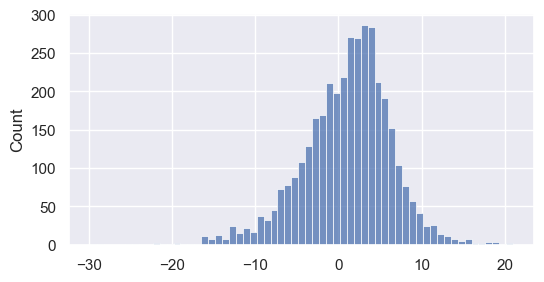

In [49]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=predictions)
plt.savefig('tfidf_linear_predictions.png')

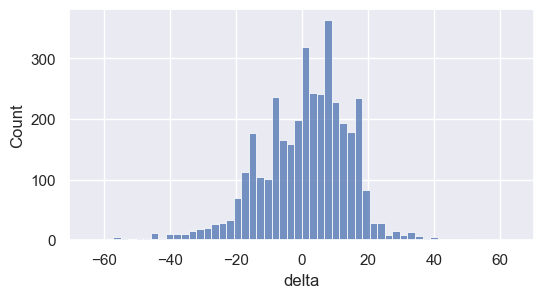

In [50]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_test)
plt.savefig('tfidf_linear_ytest.png')

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2 = r2_score(y_test, predictions)
r2

0.1758836524732681